![digitizing_team](digitizing_team.png)


DigiNsure Inc. is an innovative insurance company focused on enhancing the efficiency of processing claims and customer service interactions. Their newest initiative is digitizing all historical insurance claim documents, which includes improving the labeling of some IDs scanned from paper documents and identifying them as primary or secondary IDs.

To help them in their effort, you'll be using multi-modal learning to train an Optical Character Recognition (OCR) model. To improve the classification, the model will use **images** of the scanned documents as input and their **insurance type** (home, life, auto, health, or other). Integrating different data modalities (such as image and text) enables the model to perform better in complex scenarios, helping to capture more nuanced information. The **labels** that the model will be trained to identify are of two types: a primary and a secondary ID, for each image-insurance type pair.

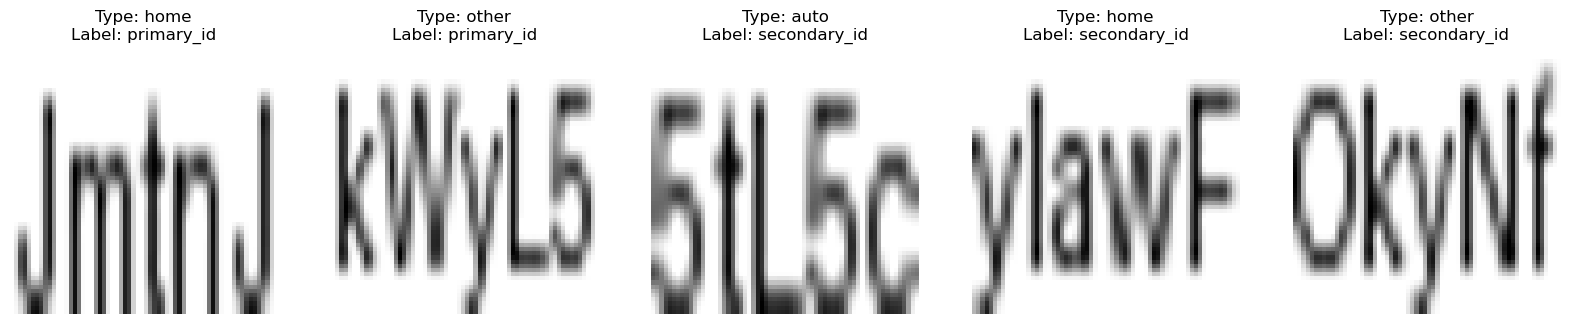

In [4]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pickle 
from project_utils import ProjectDataset

# Load the data
dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))

# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), replace=False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

# Inspect 5 codes images from the dataset
show_dataset_images(dataset)

In [7]:
# Start coding here 
import torch
import torch.nn as nn
from torchmetrics import Accuracy
from torch.utils.data import DataLoader

# checking whether the dataset is compatible with pytorch
print('='*50)
print(f"type of a sample:\n {type(dataset[0])}")
print('='*50)
print(f"example of a sample:\n {dataset[0]}")
print('='*50)

type of a sample:
 <class 'tuple'>
example of a sample:
 ((tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.8824, 0.7804, 0.7373],
         [1.0000, 1.0000, 1.0000,  ..., 0.9176, 0.7961, 0.7451],
         [1.0000, 1.0000, 1.0000,  ..., 0.9373, 0.8039, 0.7451]]]), tensor([1., 0., 0., 0., 0.])), 0)


In [8]:
# model definition 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # image layer
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ELU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(32*16*16, 128)
        )
        
        # type layer
        self.type_layer = nn.Sequential(
            nn.Linear(5, 10),
            nn.ELU()
        )
        
        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(128+10, 10),
            nn.ELU(),
            nn.Linear(10, 2),
        )
    # forward method
    def forward(self, x_image, x_type):
        x_image = self.image_layer(x_image)
        x_type = self.type_layer(x_type)
        x = torch.cat((x_image, x_type), dim=1)
        x = self.classifier(x)
        return x

In [25]:
# defining a train loop as a function
def train_loop(model, num_epoch):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    model.train()
    for epoch in range(num_epoch):
        for (images, types), labels in dataloader_train:
            optimizer.zero_grad()
            outputs = model(images, types)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(
    range(len(dataset)), test_size=0.2, random_state=10
)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# define train dataloaders
dataloader_train = DataLoader(
    train_dataset, 
    batch_size=10, 
    shuffle=True
)
# initiating the model and training
OCRModel = Net()
train_loop(OCRModel, 100)

Epoch 1, Loss: 0.6982936263084412
Epoch 2, Loss: 0.6765493750572205
Epoch 3, Loss: 0.6627159714698792
Epoch 4, Loss: 0.6888329982757568
Epoch 5, Loss: 0.7452970147132874
Epoch 6, Loss: 0.7006688117980957
Epoch 7, Loss: 0.579348087310791
Epoch 8, Loss: 0.595011830329895
Epoch 9, Loss: 0.5778076648712158
Epoch 10, Loss: 0.524808406829834
Epoch 11, Loss: 0.5793020129203796
Epoch 12, Loss: 0.5882475972175598
Epoch 13, Loss: 0.38761845231056213
Epoch 14, Loss: 0.4779500961303711
Epoch 15, Loss: 0.39691320061683655
Epoch 16, Loss: 0.3670559823513031
Epoch 17, Loss: 0.37851303815841675
Epoch 18, Loss: 0.30667930841445923
Epoch 19, Loss: 0.3583170473575592
Epoch 20, Loss: 0.2738156020641327
Epoch 21, Loss: 0.2580202519893646
Epoch 22, Loss: 0.15296797454357147
Epoch 23, Loss: 0.1277337521314621
Epoch 24, Loss: 0.23793268203735352
Epoch 25, Loss: 0.1492929458618164
Epoch 26, Loss: 0.14302915334701538
Epoch 27, Loss: 0.1735495626926422
Epoch 28, Loss: 0.14513149857521057
Epoch 29, Loss: 0.099311

In [27]:
# defining a test loop as a function
def test_loop(model):
    acc = Accuracy(task='multiclass', num_classes=2)

    model.eval()
    with torch.no_grad():
        for (images, types), labels in dataloader_test:
            outputs = model(images, types)
            _, preds = torch.max(outputs, dim=1)
            acc.update(preds, labels)

    print(f"accuracy of the model= {acc.compute()}")

# define a test dataloader
dataloader_test = DataLoader(
    test_dataset, 
    batch_size=1, 
    shuffle=False
)

# going through testing
test_loop(OCRModel)

accuracy of the model= 0.699999988079071
